# Measuring MTF from Blocks in TO4

In [1]:
%matplotlib inline
from __future__ import division, print_function

import numpy as np
from mriqa.phantoms import phantom_mask_2d, find_phantom, TO4
from mriqa.tools import show_mosaic
from mriqa.dcmio import fetch_series
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom as ndizoom
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed
from scipy.interpolate import interp1d

### Fetch a series with TO4 images. We'll pick the highest resolution (1024 matrix)

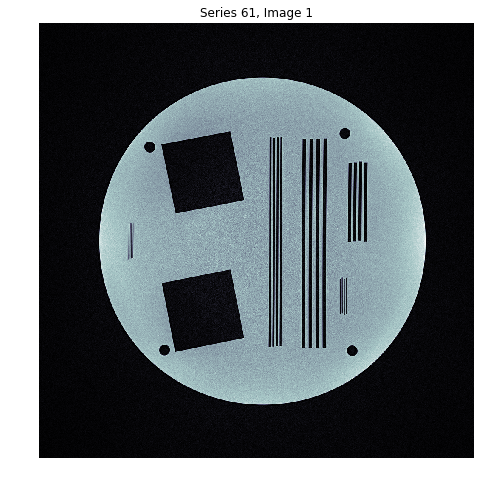

In [2]:
# TO4
dobjs = fetch_series(patid='PQA20140603RHD', sernos=[61])
images = [d.pixel_array & 0xfff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)
image = images[0].astype(float)
show_mosaic(dobjs, cmap='bone')
plt.gcf().set_size_inches(8, 8)

### Pick a ROI round one of the MTF blocks.

Matrix: 1024 x 1024
Pixel Sizes: 0.24 x 0.24 mm


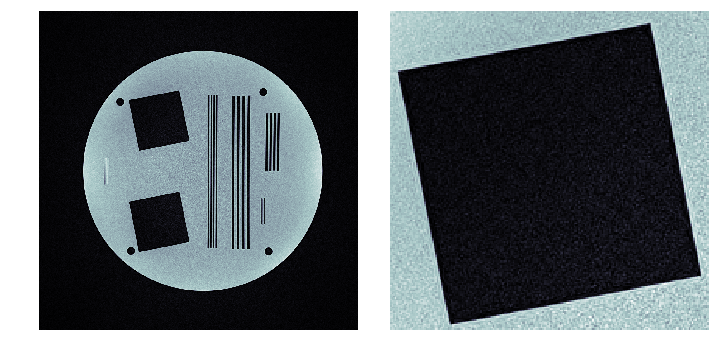

In [3]:
phantom = TO4

# Centre phantom
expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

blocks = phantom['Features']['Blocks']

(x, y), (dx, dy) = np.array(blocks[0]) / pix_dims
# are we missing an off by one adjustment here?
x += centre_x
y += centre_y

x = int(round(x))
y = int(round(y))
dx = int(round(dx))
dy = int(round(dy))

roi = image[y:y+dy, x:x+dx]

# Plotting area
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)

# Phantom image
axes[0].imshow(image, cmap='bone')
axes[0].axis('off')
axes[0].axis('image')

axes[1].imshow(roi, cmap='bone')
axes[1].axis('off')
axes[1].axis('image')

print('Matrix: %d x %d' % image.shape)
print('Pixel Sizes: %0.2f x %0.2f mm' % tuple(pix_dims))

### Fitting the Edge

Ideally, we'd like to fit a whole strip with a error function edge. This would have two parameters for the fitted straight line but also a (potentially variable?) edge width and if there is non-uniformity some sort of low order multiplier (another 3 or 4 parameters). We'll take a sub ROI around just one edge to work with.

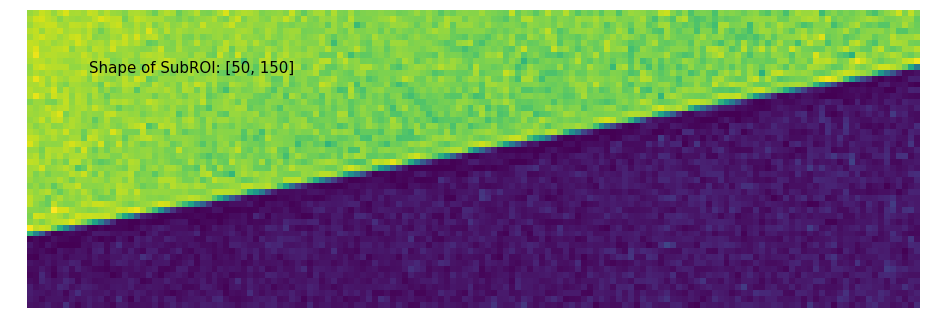

In [4]:
subroi = roi[:50, 10:160]
plt.figure(figsize=(16, 8))
plt.imshow(subroi, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.text(10, 10, 'Shape of SubROI: %s' % list(subroi.shape), fontsize=15);

We could try a simple edge detection first to get the rough slope and offset. We'll try a few different methods.

In [5]:
from skimage.filters import roberts, sobel, scharr, prewitt
method_dict = {
    'roberts': roberts,
    'sobel':   sobel,
    'scharr':  scharr,
    'prewitt': prewitt 
}

@interact(method=method_dict)
def show_edges(method):
    plt.figure(figsize=(16, 8))
    edges = method(subroi)
    plt.imshow(subroi, cmap='viridis', alpha=0.5)
    plt.imshow(edges, alpha=0.5)
    plt.grid(None)
    plt.axis('off')
    points = []
    for i, col in enumerate(edges.T):
        x, y = i, np.argmax(col)
        points.append((x, y))
    X, Y = np.asarray(points).T
    X, Y = X[1:-1], Y[1:-1]
    plt.plot(X, Y, '.', markersize=2.5)
    a, b = np.polyfit(X, Y, deg=1)
    plt.plot(X, a*X + b, linewidth=0.75)
    angle = np.degrees(np.arctan(a))
    offset = b
    plt.text(10, 10, 'Offset = %0.2f pixels; Angle (to Horizontal) = %0.2f degrees' % (offset, angle), fontsize=16)

interactive(children=(Dropdown(description='method', options={'roberts': <function roberts at 0x7fd34049a8c8>, 'sobel': <function sobel at 0x7fd34146e048>, 'scharr': <function scharr at 0x7fd34049a598>, 'prewitt': <function prewitt at 0x7fd34049a730>}, value=<function roberts at 0x7fd34049a8c8>), Output()), _dom_classes=('widget-interact',))

They all actually work pretty well. We could use this as a starting point for a more general fit and see if it makes any difference. The general function will model the edge thickness and a quadratic gain field as well as the edge position and slope.

In [6]:
from scipy.special import erfc
from scipy.optimize import curve_fit

def model(XY, i0, i1, a, b, c, d, e, f, sigma, intercept, slope):
    x, y = XY
    # quadratic model of bias field
    gain = a + b*x + c*y + d * x**2 + e * y**2 + f * x*y
    # linear model of edge position
    loc = intercept + x * slope
    # complementary error function model of edge transition
    result =  gain * (i0 + (i1 - i0) * erfc((y-loc) / sigma))
    # curve_fit() needs the image flattened to 1D
    return result.ravel()

# Coordinates
X, Y = np.meshgrid(np.arange(subroi.shape[1]), np.arange(subroi.shape[0]))

# Starting Point
i0_0 = subroi[-10:, -10:].mean()
i1_0 = subroi[:10, :10].mean()

a_0 = 1.0; b_0 = c_0 = d_0 = e_0 = f_0 = 0.0
sigma_0 = 1.0

intercept_0 = 36.67
slope_0 = -0.1895
p0 = [i0_0, i1_0, a_0, b_0, c_0, d_0, e_0, f_0, sigma_0, intercept_0, slope_0]

# Data to fit
ydata = subroi.copy()

The 'model' image using these initial parameters.

Starting parameters: [122.44, 1525.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 36.67, -0.1895]


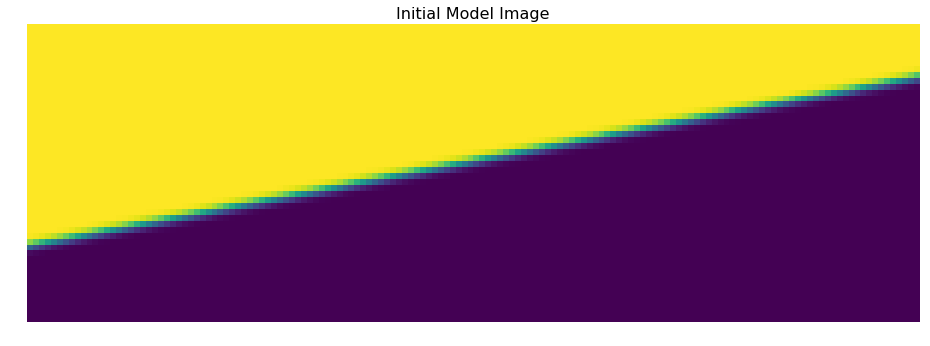

In [7]:
print('Starting parameters:', p0)

assert X.shape == Y.shape == subroi.shape
plt.figure(figsize=(16, 8))
plt.imshow(model((X, Y), *p0).reshape(ydata.shape), cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Initial Model Image', fontsize=16);

And this is the residual between that and the actual image.

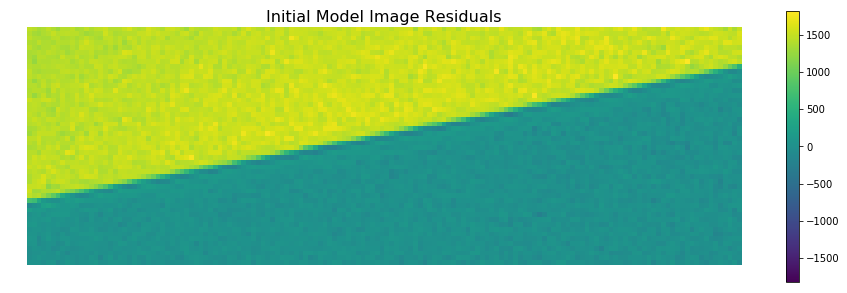

In [8]:
fig = plt.figure(figsize=(16, 5))
residuals = model((X, Y), *p0).reshape(ydata.shape)-ydata
img = plt.imshow(residuals, cmap='viridis', vmin=-residuals.max(), vmax=residuals.max())
plt.axis('off')
plt.grid(False)
plt.title('Initial Model Image Residuals', fontsize=16)
fig.colorbar(img);

Now we'll fit the model using scipy `curve_fit`.

In [9]:
popt, pcov = curve_fit(model, xdata=(X, Y), ydata=ydata.ravel(), p0=p0)
i0, i1, a, b, c, d, e, f, sigma, intercept, slope = popt
print('Offset = %0.2f pixels; Angle (to Horizontal) = %0.2f degrees, Vertical Edge Sigma = %0.2f pixels' % (intercept, np.degrees(np.arctan(slope)), sigma))

Offset = 37.25 pixels; Angle (to Horizontal) = -10.70 degrees, Vertical Edge Sigma = 0.45 pixels


This is the new model image.

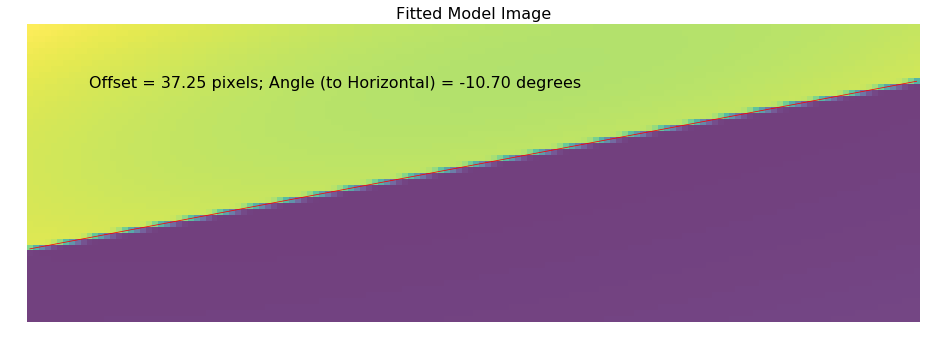

Fitted parameters:
125.42313, 1090.16810, 0.77892, -0.00218, -0.00528, 0.00001, 0.00011, 0.00004, 0.44511, 37.24987, -0.18903


In [10]:
plt.figure(figsize=(16, 8))
plt.imshow(model((X, Y), *popt).reshape(ydata.shape), cmap='viridis', alpha=0.75)
plt.axis('off')
plt.grid(False)
plt.plot(X[0], slope*X[0] + intercept, linewidth=0.75, color='red')

angle = np.degrees(np.arctan(slope))
offset = intercept
plt.text(10, 10, 'Offset = %0.2f pixels; Angle (to Horizontal) = %0.2f degrees' % (offset, angle), fontsize=16)
plt.title('Fitted Model Image', fontsize=16)
plt.show();

print('Fitted parameters:')
print(', '.join(['%0.5f' % p for p in popt]))

And the residuals now are much smaller - the fit seems pretty good.

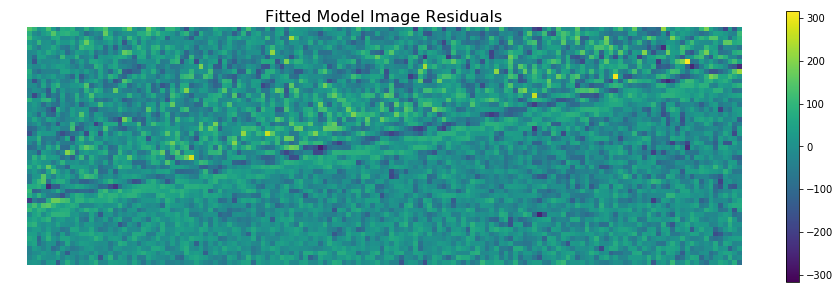

In [11]:
fig = plt.figure(figsize=(16, 5))
residuals = model((X, Y), *popt).reshape(ydata.shape)-ydata
img = plt.imshow(residuals, cmap='viridis', vmin=-residuals.max(), vmax=residuals.max())
plt.axis('off')
plt.grid(False)
plt.title('Fitted Model Image Residuals', fontsize=16)
fig.colorbar(img);

Now we have an accurate angle and intercept we need to do some sort of interpolation with offset. We'll evaluate the shifted rows on a subpixel grid. First we'll attempt a correction for non-uniformity using the fitted bias field.

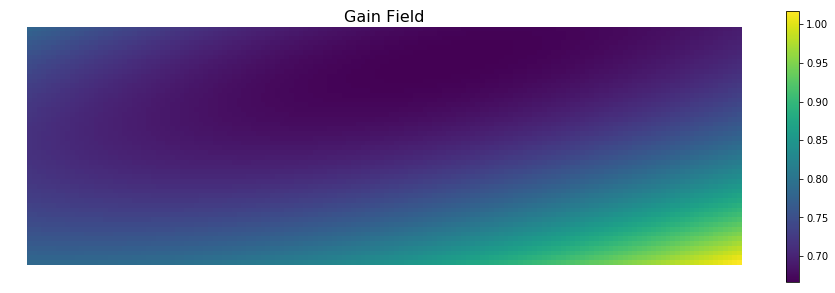

In [12]:
# quadratic model of bias field
gain = a + b*X + c*Y + d * X**2 + e * Y**2 + f * X*Y

fig = plt.figure(figsize=(16, 5))
img = plt.imshow(gain, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Gain Field', fontsize=16)
fig.colorbar(img);

### Intensity Normalization

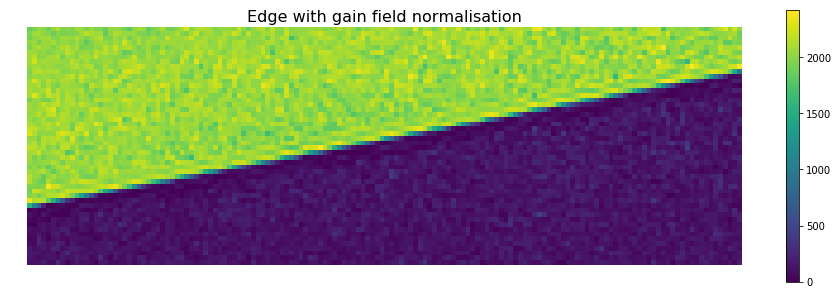

In [13]:
ydata_norm = ydata / gain
fig = plt.figure(figsize=(16, 5))
img = plt.imshow(ydata_norm, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Edge with gain field normalisation', fontsize=16)
fig.colorbar(img);

Have a look at the pixels, just by plotting there value against their distance from the nominal edge, horizontally, vertically and perpendicularly. I'm not clear what the geometric scaling factor would be for the perpendicular distance.

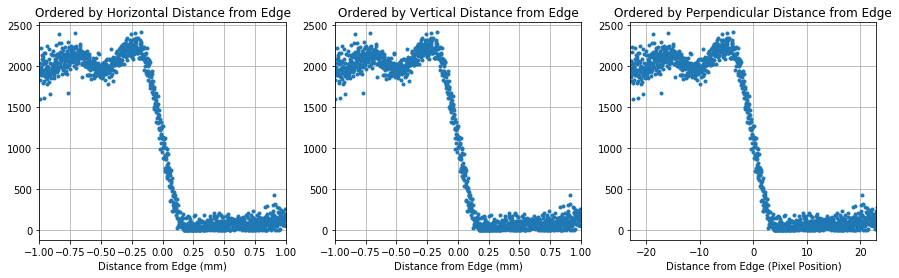

In [102]:
nrows, ncols = ydata_norm.shape

x_shifts_at_y = (np.arange(nrows) - intercept) / slope
X_shifted = (X - x_shifts_at_y[Y]).ravel()
sort_order_row = np.argsort(X_shifted)

y_shifts_at_x = np.arange(ncols) * slope + intercept
Y_shifted = (Y - y_shifts_at_x[X]).ravel()
sort_order_col = np.argsort(Y_shifted)

Perp_shifted = np.hypot(X_shifted, Y_shifted) * np.sign(X_shifted)
sort_order_perp = np.argsort(Perp_shifted)

pixvals = ydata_norm.ravel()

proj_factor_row = np.abs(np.sin(np.arctan(slope)))
proj_factor_col = np.abs(np.cos(np.arctan(slope)))
effective_pixel_size_row = pix_dims[1] * proj_factor_row
effective_pixel_size_col = pix_dims[0] * proj_factor_col

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(X_shifted[sort_order_row] * effective_pixel_size_row, pixvals[sort_order_row], '.')
axs[0].set_xlim(-1, 1)
axs[0].grid(True)
axs[0].set_xlabel('Distance from Edge (mm)')
axs[0].set_title('Ordered by Horizontal Distance from Edge')
axs[1].plot(Y_shifted[sort_order_col]  * effective_pixel_size_col, pixvals[sort_order_col], '.')
axs[1].set_xlim(-1, 1)
axs[1].grid(True)
axs[1].set_xlabel('Distance from Edge (mm)')
axs[1].set_title('Ordered by Vertical Distance from Edge')
axs[2].plot(R_shifted[sort_order_perp], pixvals[sort_order_perp], '.')
axs[2].set_xlim(-23, 23)
axs[2].grid(True)
axs[2].set_xlabel('Distance from Edge (Pixel Position)')
axs[2].set_title('Ordered by Perpendicular Distance from Edge');

Odd. They seem to be exactly the same. Have I argued round in a circle here? The width of the edge plotted like this seems to be just about the pixel size anyway - so we really don't seem to have any sub pixel information.

Maybe we could fit these points with a spline or low order polynomial - we really want them on a regular grid and smooth enough to differentiate.

We could try Gaussian Process Regression:
 - http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
 - https://blog.dominodatalab.com/fitting-gaussian-process-models-python/
 - http://scikit-learn.org/stable/modules/gaussian_process.html
 - https://stackoverflow.com/questions/24978052/interpolation-over-regular-grid-in-python
 - https://en.wikipedia.org/wiki/Kriging


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


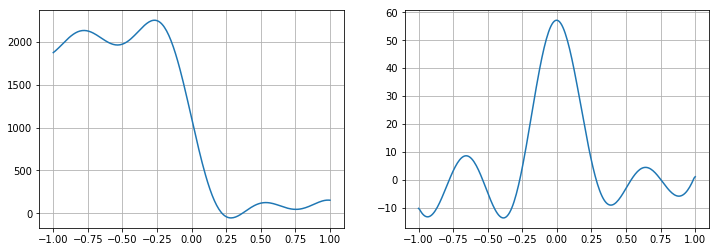

In [119]:
from sklearn.gaussian_process import GaussianProcess

locns_mm = X_shifted[sort_order_row] * effective_pixel_size_row
vals_at_locns = pixvals[sort_order_row]

# trim down +/- 1 mm
vals_at_locns = vals_at_locns[(-1 < locns_mm) & ((locns_mm < 1))]
locns_mm = locns_mm[(-1 < locns_mm) & ((locns_mm < 1))]

# argh - magic numbers - also related to number of points smoothness changes!
gp = GaussianProcess(theta0=0.1, thetaL=0.001, thetaU=1.0, nugget=0.01)
gp.fit(X=locns_mm[:, None], y=vals_at_locns)

new_locns_mm = np.linspace(-1, 1, 250)

interpolated_vals = gp.predict(new_locns_mm[:, None])

figure, axs = plt.subplots(1,2, figsize=(12, 4))
axs[0].plot(new_locns_mm, interpolated_vals)
axs[0].grid(True)
axs[1].plot(new_locns_mm, -np.gradient(interpolated_vals))
axs[1].grid(True)

Oops, looks like this is an old API - need to use `GaussianProcessRegressor` instead. But it seems to work reasonably well. There are tunable parameters though so we'd need to play with those. Also, we seem to have broadened the response significantly

### Horizontal Profile Alignment and Edge Function Construction

Now we'll align the horizontal profiles by using 1d cubic spline interpolation onto a subpixel grid, treating each row/profile independently with an alignment shift determined by the straight line fit to the edge position above. We apply a half field of view shift in `x` so as to position the profiles centrally. With the profiles crossing the edge at a shallow angle, each profile is stretched out considerably.

In [14]:
# Interpolation factor
k = 2
nrows, ncols = ydata_norm.shape
row_shifts = (np.arange(nrows) - intercept) / slope
aligned = np.zeros((nrows, k*ncols))
for row, shift in enumerate(row_shifts):
    x, y = np.arange(ncols) - shift, ydata_norm[row]
    poly = interp1d(x, y, kind='linear', bounds_error=False, fill_value=0)
    aligned[row, :] = poly(np.arange(k*ncols)/k - ncols // 2)

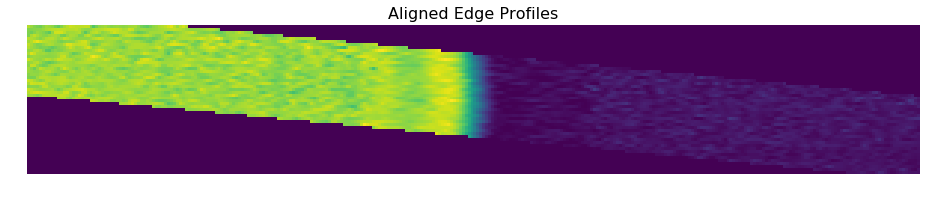

In [15]:
plt.figure(figsize=(16, 8))
plt.imshow(aligned, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Aligned Edge Profiles', fontsize=16);

Now we can select a small window around the vertical edge so that we get only complete profiles. 

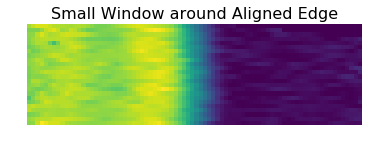

In [16]:
centre = (k*ncols)//2
window = 20*k
al_windowed = aligned[10:-16, centre-window:centre+window]
plt.figure(figsize=(6, 6))
plt.imshow(al_windowed, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Small Window around Aligned Edge', fontsize=16);

There is the suggestion of a slight bowing in the profile positions so maybe there is a residual problem with the alignment. A few individual profiles also seem a bit mis-positioned.

We now project the profiles together vertically to get the edge response. In scaling the response we need to take account of the interpoaltion above and the geometric scaling from the angle of the block, which we determined above in the fitting. 

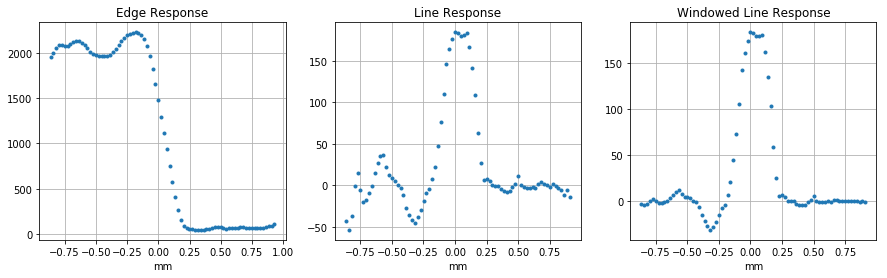

Real Pixel Size: 0.244140625 mm
Projected Pixel Size: 0.0453464049062 mm
Effective Pixel Size: 0.0226732024531 mm
Line Response Length: 79


In [26]:
from scipy.signal import hamming

edge_response = al_windowed.mean(axis=0)
line_response = -np.diff(edge_response)
windowed_line_response = line_response * hamming(len(line_response))

proj_factor = np.abs(np.sin(np.arctan(slope)))

effective_pixel_size = pix_dims[1] / k * proj_factor

pk_ind = np.argmax(line_response)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

x_axis_edge = (np.arange(len(edge_response)) - pk_ind) * effective_pixel_size
axs[0].plot(x_axis_edge, edge_response, '.')
axs[0].set_title('Edge Response')
axs[0].set_xlabel('mm')
axs[0].grid(True)

x_axis_line = (np.arange(len(line_response)) - pk_ind) * effective_pixel_size
axs[1].plot(x_axis_line, line_response, '.')
axs[1].set_title('Line Response')
axs[1].set_xlabel('mm')
axs[1].grid(True);

axs[2].plot(x_axis_line, windowed_line_response, '.')
axs[2].set_title('Windowed Line Response')
axs[2].set_xlabel('mm')
axs[2].grid(True)
plt.show()

print('Real Pixel Size:', pix_dims[1], 'mm')
print('Projected Pixel Size:', pix_dims[1] * proj_factor, 'mm')
print('Effective Pixel Size:', effective_pixel_size, 'mm')
print('Line Response Length:', len(line_response))

The MTF should be the Fourier transform of the line response. We should try and centre the response really, but the offset should (by the fourier shift theorem) just generate a phase modulation and we are only interested in the magnitude so it doesn't really matter. 

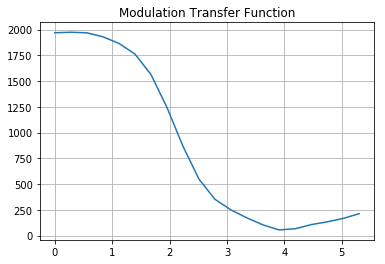

In [21]:
from numpy.fft import rfft, fftshift, fft
npoints = len(windowed_line_response)
mtf = np.abs(rfft(np.pad(windowed_line_response, npoints//2, mode='constant')))
x_mtf = np.arange(2*len(mtf)) / len(windowed_line_response) / effective_pixel_size / 2 
#x_mtf = fftfreq(len(windowed_line_response), effective_pixel_size)
plt.plot(x_mtf[:20], mtf[:20])
plt.title('Modulation Transfer Function')
plt.grid(True);

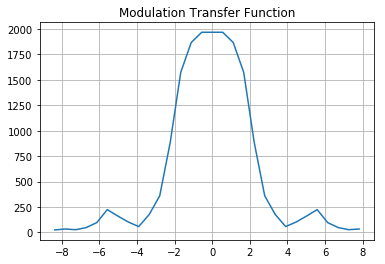

In [22]:
from scipy.signal import hamming
from numpy.fft import rfft, fftshift, fft, fftfreq
mtf = np.abs(fft(windowed_line_response))
x_mtf = fftfreq(len(mtf), effective_pixel_size)
centre = len(mtf) // 2
plt.plot(fftshift(x_mtf)[centre-15:centre+15], fftshift(mtf)[centre-15:centre+15])
plt.title('Modulation Transfer Function')
plt.grid(True);

### Vertical Profile Alignment and Edge Function Construction

We'll try using vertical profiles instead, ie cutting the edge at a steep rather than shallow angle. This is what we originally thought and means that the edge is spread out much less in each individual profile but the profiles are *staggered* more finely. Again, we'll align the profiles by using 1d cubic spline interpolation onto a subpixel grid, treating each column/profile, this time, independently with an alignment shift determined by the same straight line fit to the edge position above. We apply a half field of view shift in `y`, this time, so as to postion the profiles centrally. We'll also need a higher interpolation factor in this case as the profile positions change more slowly.

In [120]:
# Interpolation factor
k = 8
nrows, ncols = ydata_norm.shape
col_shifts = 1.0 * slope * np.arange(ncols) + intercept
aligned = np.zeros((k*nrows, ncols))
for col, shift in enumerate(col_shifts):
    x, y = np.arange(nrows) - shift, ydata_norm[:, col]
    
    poly = interp1d(x, y, kind='nearest', bounds_error=False, fill_value=0)
    aligned[:, col] = poly(np.arange(k*nrows) / k - nrows // 2)

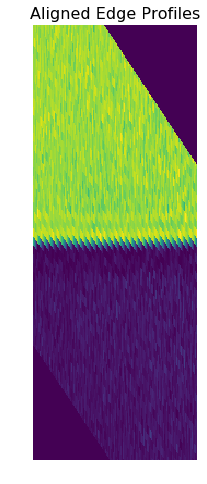

In [121]:
plt.figure(figsize=(16, 8))
plt.imshow(aligned, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Aligned Edge Profiles', fontsize=16);

Now we can select a small window around the vertical edge so that we get only complete profiles. 

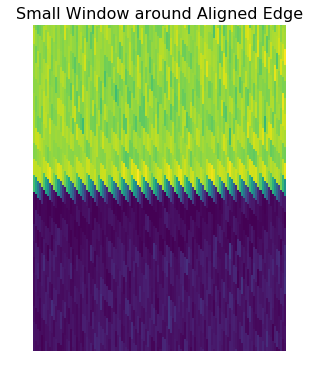

In [122]:
centre = (k*nrows)//2
window = 10*k
al_windowed = aligned[centre-window:centre+window, 10:-16]
plt.figure(figsize=(6, 6))
plt.imshow(al_windowed, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Small Window around Aligned Edge', fontsize=16);

There is a definite ripple in the profile positions. This suggests there is still a problem with the alignment. This will have quite a significant blurring effect on the edge response when we sum them.

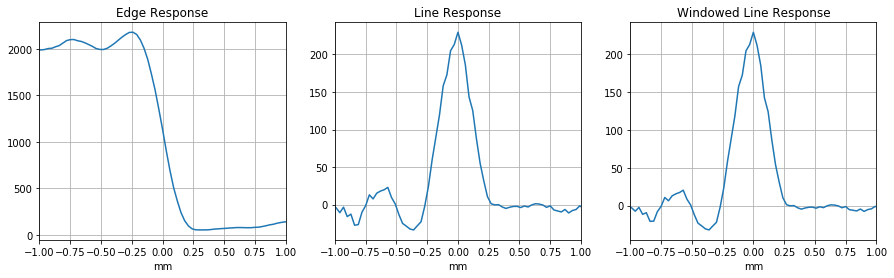

Real Pixel Size: 0.244140625 mm
Projected Pixel Size: 0.239892368235 mm
Effective Pixel Size: 0.0299865460294 mm
Line Response Length: 159


In [123]:
from scipy.signal import hamming

edge_response = al_windowed.mean(axis=1)
line_response = -np.diff(edge_response)
windowed_line_response = line_response * hamming(len(line_response))

proj_factor = np.abs(np.cos(np.arctan(slope)))

effective_pixel_size = pix_dims[1] / k * proj_factor

pk_ind = np.argmax(line_response)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

x_axis_edge = (np.arange(len(edge_response)) - pk_ind) * effective_pixel_size
axs[0].plot(x_axis_edge, edge_response)
axs[0].set_title('Edge Response')
axs[0].set_xlabel('mm')
axs[0].set_xlim(-1, 1)
axs[0].grid(True)

x_axis_line = (np.arange(len(line_response)) - pk_ind) * effective_pixel_size
axs[1].plot(x_axis_line, line_response)
axs[1].set_title('Line Response')
axs[1].set_xlabel('mm')
axs[1].set_xlim(-1, 1)
axs[1].grid(True);

axs[2].plot(x_axis_line, windowed_line_response)
axs[2].set_title('Windowed Line Response')
axs[2].set_xlabel('mm')
axs[2].grid(True)
axs[2].set_xlim(-1, 1)

plt.show()

print('Real Pixel Size:', pix_dims[1], 'mm')
print('Projected Pixel Size:', pix_dims[1] * proj_factor, 'mm')
print('Effective Pixel Size:', effective_pixel_size, 'mm')
print('Line Response Length:', len(line_response))

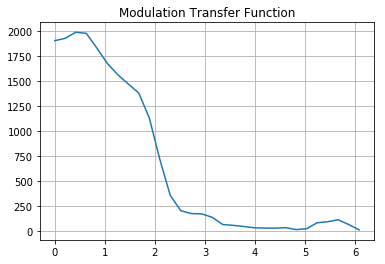

In [64]:
from numpy.fft import rfft, fftshift, fft
mtf = np.abs(rfft(windowed_line_response))
x_mtf = np.arange(len(mtf)) / len(windowed_line_response) / effective_pixel_size 
#x_mtf = fftfreq(len(windowed_line_response), effective_pixel_size)
plt.plot(x_mtf[:30], mtf[:30])
plt.title('Modulation Transfer Function')
plt.grid(True);

Don't really seem to be getting much subpixel information. The first minimum seems to be at 4 lp/mm and our pixel resolution is about 0.25 mm (check there isn't a factor 2 gone missing here ...) We should surely be down below 100 microns for diffusion etc. What about the T2 broadening - what does 30ms correspond to? Need 30ms -> Hz cf Hz/Pixel.
We could maybe do with an experiment (at high SNR) for a range of TEs and maybe a 3D sequence in case we are getting blurring from any slice angulation - it wouldn't need much if we are down at 250 microns.

In [65]:
# Integer Alignment
nrows, ncols = ydata.shape
column_shifts = slope * np.arange(ncols)
whole_shifts = np.floor(column_shifts).astype(int)
int_aligned = np.zeros_like(ydata)
for col, shift in enumerate(whole_shifts):
    int_aligned[:, col] = np.roll(ydata[:, col], -shift)
    # all shifts will be negative - patch up leading edge
    if shift < 0:
        int_aligned[:-shift, col] = ydata[0, col]

# Interpolation
k = 16
nrows, ncols = ydata_norm.shape
int_aligned_interp = np.zeros((k*nrows, ncols))
for col in range(ncols):
    x, y = np.arange(nrows), int_aligned[:, col]
    poly = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=0)
    int_aligned_interp[:, col] = poly(np.arange(k*nrows) / k)

# Fractional Alignment
aligned = np.zeros_like(int_aligned_interp)
fractional_shifts = (k * (column_shifts - np.floor(column_shifts))).astype(int)
for col, shift in enumerate(fractional_shifts):
    aligned[:, col] = np.roll(int_aligned_interp[:, col], -shift)
    # all shifts will be positive - patch up trailing edge
    if shift > 0:
        aligned[-shift:, col] = int_aligned_interp[-1, col]


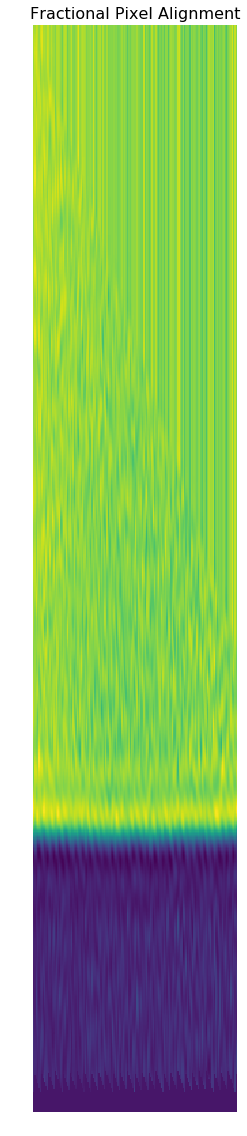

In [66]:
plt.figure(figsize=(5, 20))
plt.imshow(aligned, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Fractional Pixel Alignment', fontsize=16);

How can we test/validate this? We could start with a very high resolution image with a sharp angled edge with say a small degree of gaussian blurring. Then we interpolate on to a courser grid (band-limited - sinc ..). Could do this in the fourier domain. Need to think a little about any k-space filtering/antialiasing that might have been applied. If we start with a true resolution of say 50-100 microns so with a pixel resolution say 20 microns. Then sample to 250 or 500 microns. 

In [67]:
from scipy.ndimage.filters import gaussian_filter
nrows, ncols = ydata_norm.shape
sigma_mm = 0.01
sigma_pixels = k * sigma_mm / pix_dims[1]
k = 48
yy, xx = np.mgrid[:k*nrows, :k*ncols]
original = yy / k < intercept + (xx / k) * slope
original = gaussian_filter(original, sigma_pixels, mode='nearest')

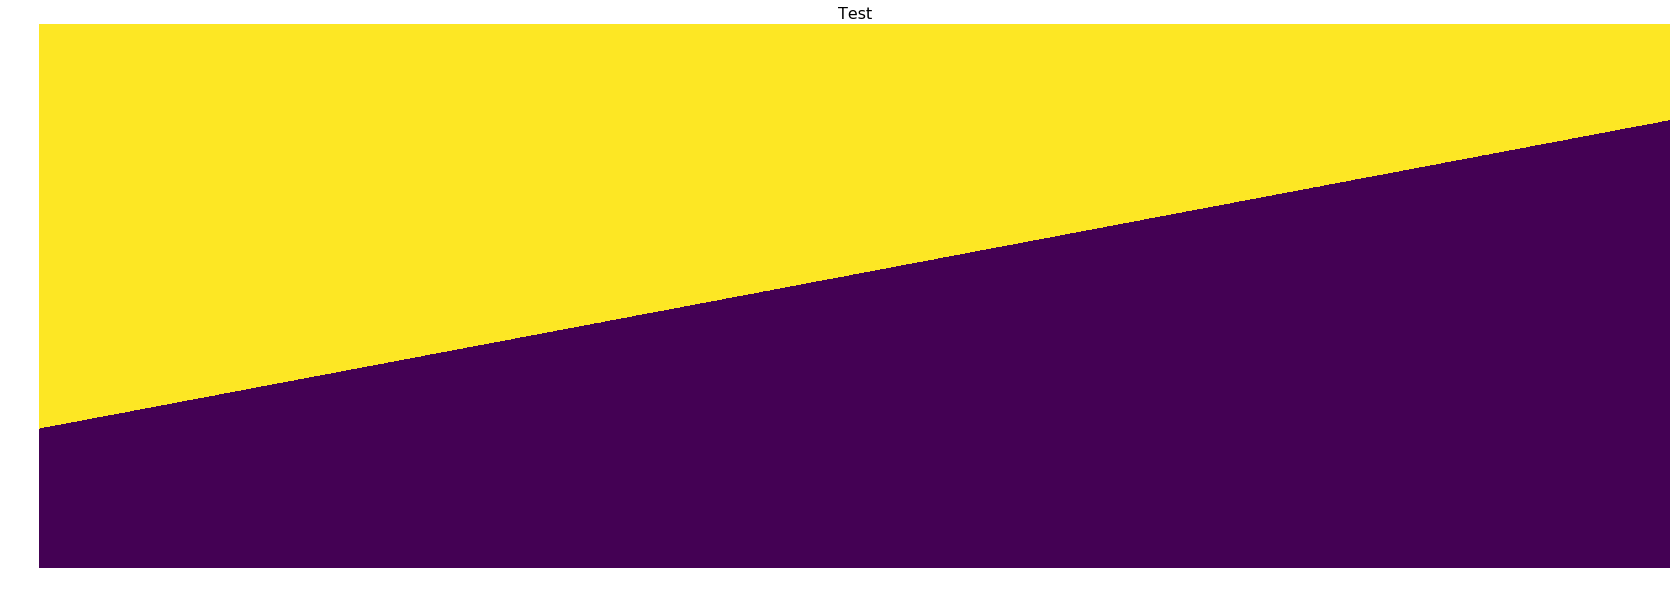

In [68]:
plt.figure(figsize=(30, 10))
plt.imshow(original, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Test', fontsize=16);

In [69]:
#from numpy.fft import fft2, ifft2
#subsampled = np.abs(ifft2(fft2(original)[:nrows, :ncols]))
from scipy.signal import resample
subsampled = resample(resample(original, nrows, axis=0, window='hann'), ncols, axis=1, window='hann')

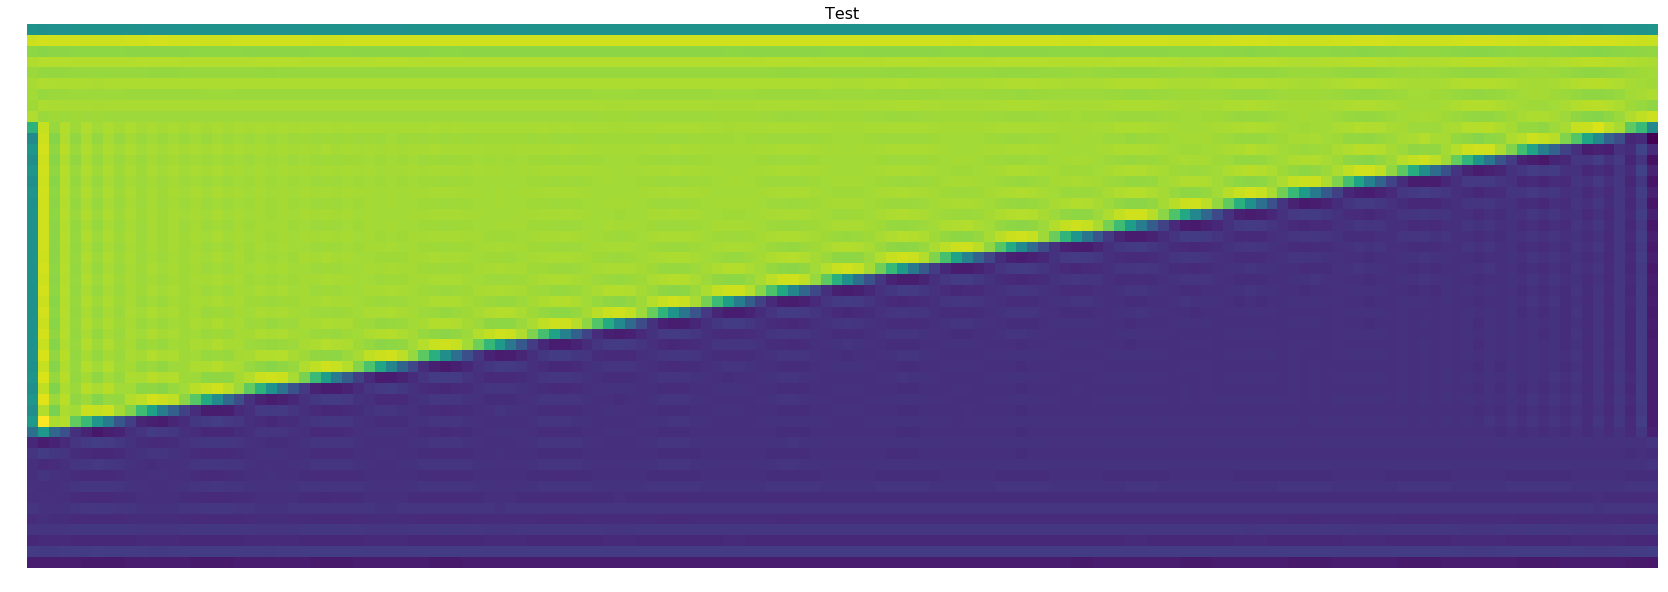

In [70]:
plt.figure(figsize=(30, 10))
plt.imshow(subsampled, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Test', fontsize=16);

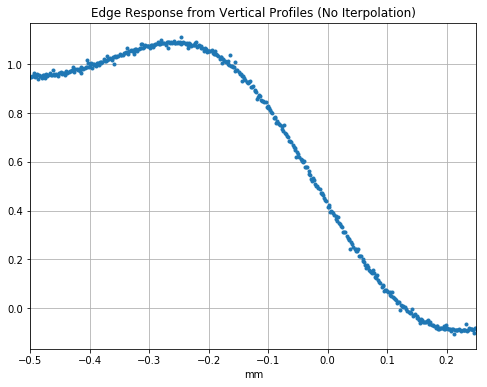

In [71]:
col_shifts = np.arange(ncols) * slope + intercept
x, y = [], []
for col, shift in enumerate(col_shifts):
    if 2 < col < ncols-3: 
        x += list(np.arange(nrows) - shift)[3:-3]
        y += list(subsampled[:, col])[3:-3]
x, y = np.asarray(sorted(zip(x, y))).T

plt.figure(figsize=(8, 6))
plt.plot(x * pix_dims[1] * proj_factor, y, '.')
plt.xlim(-0.5, 0.25)
plt.title('Edge Response from Vertical Profiles (No Iterpolation)')
plt.xlabel('mm')
plt.grid(True);

The way the edge response seems to be done normally is either use binning or to just plot each pixel at its inferred position on the edge as a point. Presumably we could extend this by taking this unevenly spaced data and applying a KDE or a known fitting function (erf, exponential, integral of sinc ("sine intergral"?) ?) Let's try approaching it like that. We'll use the vertical profiles as that seems to be what is done normally.

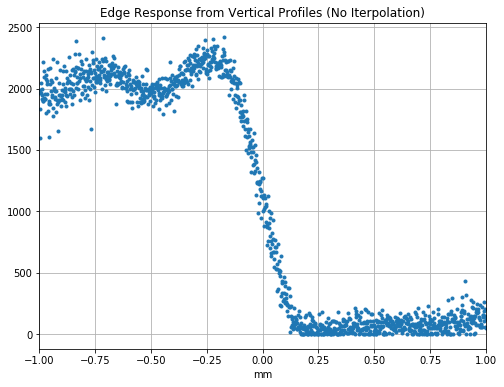

In [72]:
nrows, ncols = ydata_norm.shape

col_shifts = np.arange(ncols) * slope + intercept
x, y = [], []
for col, shift in enumerate(col_shifts):
    x += list(np.arange(nrows) - shift)
    y += list(ydata_norm[:, col])
x, y = np.asarray(sorted(zip(x, y))).T

plt.figure(figsize=(8, 6))
plt.plot(x * pix_dims[1] * proj_factor, y, '.')
plt.xlim(-1, 1)
plt.title('Edge Response from Vertical Profiles (No Iterpolation)')
plt.xlabel('mm')
plt.grid(True);

Really doesn't look like it is any narrower than the pixel resolution of 0.25mm ..

In [ ]:
TE = 30e-3 # (ms)
BW = 130 # Hz
1 / TE / BW * pix_dims[1]

We could further fit a low order polynomial to the edge here to further refine the aligment before projecting. There is a slight bowing. We also have a potential issue with the asymmetry of the line spread function, which is at least partly due to the fact that we are working with a magnitude image and the backgound is (roughly) at zero. If we had a non-zero background that might help with that. Note we also have a small spike in the MTF - not sure if that comes from the asymmetry. 

This is in lines per pixel in interpolated image. We need to divide? by k to get lines per pixel in the original image. Then we need to scale by the projection angle of the edge (multiply by $\sin \alpha$ or $\tan \alpha$ ?) and finally divide by the pixel size to lines per mm.

In [ ]:
x_axis = np.arange(len(mtf)) / k / abs(slope) / pix_dims[0]
plt.plot(x_axis[:16], mtf[:16]);

There does seem to be a bit of a mess at the lower spatial frequencies. That may be from the rather obvious ripple in the ESF/LSF. Maybe this would average out if we combined the estimates from mulitiple edges. Have a look at log transformed data and see if it is any better. How is it normally presented? We may want to change the interpolation scheme - maybe we need to window the sinc interpolation to fix the ringing. If we don't have a clean low frequency part it's a bit difficult to estimate the frequency at one half maximum. We could throw away the outer edges of the LSF as they are not very meaningful past 2 or 3 mm. We also didn't apply the non uniformity correction from the model fit - that might help a bit.

In [ ]:
plt.plot(x_axis[:16], np.log(mtf)[:16]);

Something doesn't seem right here. We don't seem to have gained any subpixel resolution in the edge function. Is there something wrong with the method? Should we be using binning instead? Or, better, a KDE.

For each actual pixel we should know its extrapolated position on the edge. If we generate a KDE for this unevenly spaced data we should have the edge spread function. How do we get the position on the edge for each pixel? It's just the distance from the pixel centre to the edge regression line.

In [ ]:
nrows, ncols = subroi.shape
distances = np.arange(nrows)[:, None] * np.ones(ncols)[None, :] - (intercept + slope * np.arange(ncols))
plt.imshow(distances, cmap='coolwarm')
plt.axis('off')
plt.grid(False)
plt.title('Vertical Distance from Edge in pixels')
plt.colorbar();

OK, this looks right - we have a smoothly varying distance from edge. What we actually need now is a *weighted* KDE. That is each point adds in with a multiplicity proportional to the image intensity. Otherwise, we'd need to convert the pixel values into some sort of multiplicity manually, which sounds slow and messy and would greatly increase the size of the problem. The sklearn and scipy kernel density estimators don't seem to support this, but it looks like the statsmodels one might.

In [ ]:
nrows, ncols = subroi.shape
plt.imshow(subroi, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.colorbar();

In [ ]:
import statsmodels.api as sm
d = distances[np.abs(distances) < 8]
w = subroi[np.abs(distances) < 8].astype('float')

kde = sm.nonparametric.KDEUnivariate(d)
kde.fit(fft=False, weights=w, bw=0.25)
# in pixels
x = np.linspace(-3, 3, 1024)
esf = kde.evaluate(x)
lsf = -np.gradient(esf)
mtf = abs(np.fft.fft(lsf))
freqs = np.fft.fftfreq(len(lsf), x[1]-x[0])
mtf = np.fft.fftshift(mtf)
freqs = np.fft.fftshift(freqs)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].plot(x * pix_dims[0], esf)
axs[1].plot(x * pix_dims[0], lsf)
axs[2].plot(freqs / pix_dims[0], mtf, '-')
axs[2].set_xlim([0, 6])

This still doesn't seem to be giving us any subpixel resolution ... OK, the inner portion of this looks reasonable (it goes pretty crazy outside of +/- 6 pixels). There is also a problem with the bandwidth. A larger (including the default) bandwidth seems to wash out the esf, and a lower one makes a very noise lsf with lots of spikes in the msf. We've also got hardly any points across the mtf.

----

----

----